# UR SLS Sentinel 10m TC

Kode modelling klasifikasi densenet dan resnet urban rural pada data sentinel 2 10m dengan neighbor True crop, input tingkat SLS.

### Import Fast AI

In [1]:
import fastai
from fastai.vision.all import *
import pandas as pd

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,balanced_accuracy_score
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/dataset/UR/06. Sentinel 10M SLS ES.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [5]:
import matplotlib.pyplot as plt
from sklearn import metrics

In [6]:
def plot_multroc(tst_preds, k =5):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots( figsize=(9,7))
    for i in range(0,k):
        fpr, tpr, thresholds = metrics.roc_curve(tst_preds[i][1], tst_preds[i][0][:,1])
        roc_auc = metrics.auc(fpr, tpr)
        viz = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name="ROC fold {}".format(i))
        viz.plot(ax = ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.35,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")

    plt.show()

def cal_faccu(path , thres = 0.5):
  valt = []
  dataset = pd.read_csv(path)
  for i in range(1,6) :
    temp = dataset.loc[dataset.fold == i].copy()
    temp.loc["pred_lab"] = 0
    temp.loc[temp.pred > thres,"pred_lab"] = 1
    metri = [accuracy_score( temp.true,temp.pred_lab),balanced_accuracy_score( temp.true,temp.pred_lab),precision_score( temp.true,temp.pred_lab), recall_score( temp.true,temp.pred_lab),recall_score( temp.true,temp.pred_lab,pos_label = 0), f1_score( temp.true,temp.pred_lab),roc_auc_score( temp.true,temp.pred_lab)]
    valt.append(metri)
  print(pd.DataFrame(valt).mean())

### Preprocessing Image Input SLS

In [12]:
path = Path.cwd() / ("06. Sentinel 10M SLS ES")

### Densenet 

Pemodelan di tingat sls dengan densenet

In [13]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metricsc=[accuracy,bc, Precision(), Recall(),Recall(pos_label=0), f1s, roca]


In [14]:
val_pct = []
tst_preds = []
datasetr = []
for kf in range(1,6):
  blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items=get_image_files, # finds the images in the path
                  splitter=FileSplitter("/content/drive/MyDrive/Colab Notebooks/dataset/UR/kfold"+str(kf)+".txt"),  # default random split 80% training, 20% validation
                  get_y=parent_label # extracts the label category from the image's folder name 
                  )
  dls = blocks.dataloaders(path,bs = 768)
  learn = vision_learner(dls, densenet121, metrics=metricsc) 
  learn.fit_one_cycle(4,1e-2)
  preds,label = learn.get_preds(ds_idx  = 1)
  idx_test = []
  for i in dls.valid.items:
      idx_test.append(str(i)[-18:-4])
  true_label = []
  for i in dls.valid.items:
      if("urban" in str(i)) :
          true_label.append(1)
      else :
          true_label.append(0)

  test = pd.DataFrame(preds)
  test["idsls"] = idx_test
  test["true_lab"] = true_label
  test["iddesa"] = test.idsls.str[:10]
  test["stat"] = round(test[1])
  desa_pred_test = test.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})
  desa_pred_test.columns = ["pred","true"]
  desa_pred_test["pred_lab"] = 0
  desa_pred_test["fold"] = kf
  datasetr.append(desa_pred_test)
  desa_pred_test.loc[desa_pred_test.pred > 0.825,"pred_lab"] = 1
  metri = [accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab),balanced_accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab),precision_score( desa_pred_test.true,desa_pred_test.pred_lab), recall_score( desa_pred_test.true,desa_pred_test.pred_lab),recall_score( desa_pred_test.true,desa_pred_test.pred_lab,pos_label = 0), f1_score( desa_pred_test.true,desa_pred_test.pred_lab),roc_auc_score( desa_pred_test.true,desa_pred_test.pred_lab)]
  val_pct.append(metri)
  tst_preds.append((TensorBase([1-desa_pred_test.pred,desa_pred_test.pred]).T , TensorCategory(desa_pred_test.true)))

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.390847,0.387191,0.816383,0.706365,0.855584,0.914188,0.498543,0.722446,0.852749,01:43
1,0.352845,0.384853,0.811842,0.638106,0.819835,0.966294,0.309919,0.661866,0.863854,01:39
2,0.344129,0.371622,0.820804,0.672698,0.836030,0.952471,0.392925,0.699159,0.868628,01:39
3,0.329150,0.367768,0.823429,0.701651,0.851414,0.931690,0.471611,0.723339,0.869481,01:39


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.385492,0.386903,0.818819,0.671737,0.839324,0.945304,0.398170,0.696578,0.853131,01:39
1,0.351556,0.380525,0.825494,0.692326,0.849149,0.940015,0.444637,0.716576,0.867199,01:39
2,0.343641,0.368094,0.824342,0.673978,0.839646,0.953650,0.394306,0.701158,0.870333,01:39
3,0.326288,0.366780,0.826152,0.703348,0.855107,0.931760,0.474936,0.724960,0.871009,01:39


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.435729,26.940018,0.730157,0.706014,0.895545,0.747127,0.664901,0.659431,0.799074,01:40
1,0.364220,0.355591,0.830604,0.674762,0.859570,0.940145,0.409378,0.698718,0.862279,01:39
2,0.351051,0.352283,0.830115,0.673411,0.859010,0.940263,0.406560,0.697368,0.864250,01:39
3,0.343501,0.350752,0.831930,0.696781,0.869839,0.926926,0.466637,0.715748,0.866386,01:39


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.379080,0.407129,0.812344,0.701545,0.861206,0.903309,0.499780,0.713681,0.846405,01:40
1,0.354543,0.379564,0.814523,0.676118,0.847038,0.928153,0.424083,0.696668,0.853437,01:39
2,0.338514,0.372272,0.819254,0.676874,0.846699,0.936147,0.417601,0.699690,0.859239,01:39
3,0.324844,0.374617,0.820764,0.687196,0.851844,0.930424,0.443968,0.708491,0.859521,01:40


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.421267,0.480718,0.748797,0.749448,0.916629,0.748308,0.750589,0.692793,0.831668,01:40
1,0.359363,0.373323,0.821951,0.701415,0.867746,0.912427,0.490403,0.715507,0.852539,01:39
2,0.349470,0.367556,0.822312,0.653614,0.844211,0.948939,0.358289,0.678600,0.855661,01:40
3,0.331415,0.367563,0.823443,0.697019,0.865203,0.918339,0.475699,0.713497,0.856819,01:39


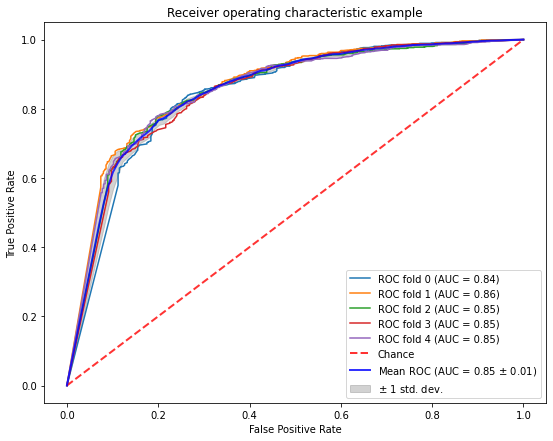

In [15]:
plot_multroc(tst_preds, k = 5)

In [16]:
pd.DataFrame(val_pct).mean()

0    0.803179
1    0.773833
2    0.878074
3    0.841851
4    0.705814
5    0.859536
6    0.773833
dtype: float64

In [17]:
dat = datasetr[0]
for i in range(1,5) :
  dat = pd.concat([dat,datasetr[i]],axis = 0,ignore_index = True)
dat.to_csv("/content/drive/MyDrive/Colab Notebooks/validate/06. fold densenet.csv")

In [18]:
pd.DataFrame(val_pct).to_csv("/content/drive/MyDrive/Colab Notebooks/validate/06. densenet.csv")

In [19]:
file_name = "/content/drive/MyDrive/Colab Notebooks/pickle predictions/06. densenet predictions.pkl"
with open(file_name, "wb") as fp:   #Pickling
   pickle.dump(tst_preds, fp)

In [20]:
cal_faccu("/content/drive/MyDrive/Colab Notebooks/validate/06. fold densenet.csv",0.775)

0    0.809832
1    0.760864
2    0.861428
3    0.874864
4    0.646865
5    0.868026
6    0.760864
dtype: float64


### Resnet

In [21]:
val_pct_rs = []
tst_preds_rs = []
datasetr_rs = []
for kf in range(1,6):
  blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items=get_image_files, # finds the images in the path
                  splitter=FileSplitter("/content/drive/MyDrive/Colab Notebooks/dataset/UR/kfold"+str(kf)+".txt"),  # default random split 80% training, 20% validation
                  get_y=parent_label # extracts the label category from the image's folder name 
                  )
  dls = blocks.dataloaders(path,bs = 768)
  learn_rs = vision_learner(dls, resnet50, metrics=metricsc) 
  learn_rs.fit_one_cycle(4,1e-2)
  preds,label = learn_rs.get_preds(ds_idx  = 1)
  idx_test = []
  for i in dls.valid.items:
      idx_test.append(str(i)[-18:-4])
  true_label = []
  for i in dls.valid.items:
      if("urban" in str(i)) :
          true_label.append(1)
      else :
          true_label.append(0)

  test = pd.DataFrame(preds)
  test["idsls"] = idx_test
  test["true_lab"] = true_label
  test["iddesa"] = test.idsls.str[:10]
  test["stat"] = round(test[1])
  desa_pred_test = test.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})
  desa_pred_test.columns = ["pred","true"]
  desa_pred_test["pred_lab"] = 0
  desa_pred_test["fold"] = kf
  datasetr_rs.append(desa_pred_test)
  desa_pred_test.loc[desa_pred_test.pred > 0.825,"pred_lab"] = 1
  metri = [accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab),balanced_accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab),precision_score( desa_pred_test.true,desa_pred_test.pred_lab), recall_score( desa_pred_test.true,desa_pred_test.pred_lab),recall_score( desa_pred_test.true,desa_pred_test.pred_lab,pos_label = 0), f1_score( desa_pred_test.true,desa_pred_test.pred_lab),roc_auc_score( desa_pred_test.true,desa_pred_test.pred_lab)]
  val_pct_rs.append(metri)
  tst_preds_rs.append((TensorBase([1-desa_pred_test.pred,desa_pred_test.pred]).T , TensorCategory(desa_pred_test.true)))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.390447,0.384387,0.817801,0.700580,0.851910,0.922011,0.479148,0.719338,0.853269,01:37
1,0.355093,0.373102,0.822980,0.683965,0.841674,0.946564,0.421365,0.709697,0.865630,01:33
2,0.343434,0.370866,0.825321,0.685774,0.842254,0.949378,0.422169,0.712378,0.868991,01:33
3,0.326363,0.368788,0.825605,0.704743,0.852754,0.933051,0.476435,0.726797,0.869430,01:33


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.387704,0.378863,0.819618,0.657858,0.832175,0.958726,0.356990,0.684398,0.863719,01:34
1,0.355656,0.373602,0.821733,0.671464,0.838744,0.950960,0.391967,0.697727,0.864432,01:33
2,0.342845,0.369377,0.824060,0.681581,0.843647,0.946588,0.416573,0.707384,0.867701,01:33
3,0.329265,0.368736,0.827868,0.695327,0.850360,0.941849,0.448805,0.720181,0.870893,01:33


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.390984,0.409209,0.811017,0.744990,0.899729,0.857428,0.632552,0.729090,0.855077,01:34
1,0.360331,0.361811,0.827138,0.648099,0.848014,0.952984,0.343215,0.673925,0.854588,01:33
2,0.348034,0.350435,0.831674,0.704418,0.873645,0.921122,0.487714,0.720687,0.866699,01:33
3,0.327586,0.349799,0.830255,0.703899,0.873617,0.919070,0.488729,0.719410,0.866852,01:32


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.381519,0.390695,0.817495,0.660005,0.838458,0.946795,0.373215,0.684520,0.849771,01:33
1,0.351796,0.387901,0.818634,0.658325,0.837485,0.950248,0.366403,0.683489,0.856007,01:33
2,0.339005,0.374310,0.821483,0.684933,0.850535,0.933589,0.436278,0.707177,0.859549,01:33
3,0.325830,0.376699,0.821829,0.682704,0.849314,0.936051,0.429356,0.705648,0.858662,01:33


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.391096,0.393487,0.816368,0.707452,0.871974,0.898122,0.516781,0.715840,0.842883,01:33
1,0.355644,0.385685,0.819882,0.710300,0.872859,0.902135,0.518464,0.719834,0.847135,01:33
2,0.345201,0.368450,0.823467,0.693239,0.863257,0.921218,0.465260,0.710911,0.858100,01:33
3,0.331095,0.370020,0.821759,0.696314,0.865120,0.915919,0.476709,0.711988,0.857985,01:33


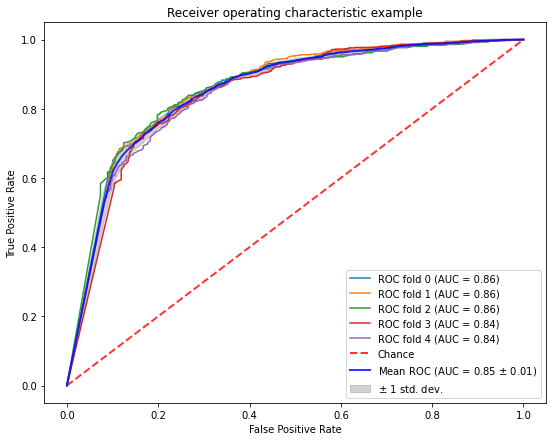

In [22]:
plot_multroc(tst_preds_rs, k = 5)

In [23]:
pd.DataFrame(val_pct_rs).mean()

0    0.804382
1    0.774029
2    0.877327
3    0.845199
4    0.702860
5    0.860781
6    0.774029
dtype: float64

In [24]:
dat_rs = datasetr_rs[0]
for i in range(1,5) :
  dat_rs = pd.concat([dat_rs,datasetr_rs[i]],axis = 0,ignore_index = True)
dat_rs.to_csv("/content/drive/MyDrive/Colab Notebooks/validate/06. fold resnet.csv")

In [25]:
pd.DataFrame(val_pct_rs).to_csv("/content/drive/MyDrive/Colab Notebooks/validate/06. resnet.csv")

In [26]:
file_name = "/content/drive/MyDrive/Colab Notebooks/pickle predictions/06. resnet predictions.pkl"
with open(file_name, "wb") as fp:   #Pickling
   pickle.dump(tst_preds_rs, fp)

In [27]:
cal_faccu("/content/drive/MyDrive/Colab Notebooks/validate/06. fold resnet.csv",0.775)

0    0.811892
1    0.765054
2    0.864253
3    0.874861
4    0.655248
5    0.869280
6    0.765054
dtype: float64
